Calculate std(w) in runs with and without bay at particular depths

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [3]:
nx = 512
ny = 612
nz = 76
dt = 600
z1 = 25 # Zl[25] = -99 m
z2 = 37 # Zl[37] = -197.2 m
z3 = 45 # Zl[45] = -292.2 m
z4 = 55 # Zl[55] = -508.2 m

depth_nob = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth_nob,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# centers mask bathy with bay
depth_bay = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)

In [4]:
def get_var(ds, ds2, tini, tend, mask, zz, time, dt=600):
    '''mask = 3D mask'''
    
    mask_ext = np.expand_dims(mask[zz,:,:],0)
    mask_ext = mask_ext + np.zeros_like(ds.variables['WVEL'][tini:tend,zz,...])
    Wmean = np.nanmean(np.ma.masked_array(ds.variables['WVEL'][tini:tend,zz,...],
                                          mask=mask_ext),axis=0)
    Wmean_ext = np.expand_dims(Wmean,0)
    Wmean_ext = Wmean_ext + np.zeros_like(ds.variables['WVEL'][tini:tend,zz,...])
    
    masked_W = np.ma.masked_array(ds.variables['WVEL'][tini:tend,zz,...],mask=mask_ext)
    var1 = dt*np.nansum((masked_W-Wmean_ext)**2,axis=0)/(time[tend]-time[tini])
    
    Wmean_nob = np.nanmean(np.ma.masked_array(ds2.variables['WVEL'][tini:tend,zz,...],
                                          mask=mask_ext),axis=0)
    Wmean_nob_ext = np.expand_dims(Wmean_nob,0)
    Wmean_nob_ext = Wmean_nob_ext + np.zeros_like(ds2.variables['WVEL'][tini:tend,zz,...])
    
    masked_W_nob = np.ma.masked_array(ds2.variables['WVEL'][tini:tend,zz,...],mask=mask_ext)
    var1_nob = dt*np.nansum((masked_W_nob-Wmean_nob_ext)**2,axis=0)/(time[tend]-time[tini])
    
    Wdif = (masked_W-Wmean_ext)-(masked_W_nob-Wmean_nob_ext)
    var1_diff = dt*np.nansum((Wdif)**2,axis=0)/(time[tend]-time[tini])
    
    return(var1, var1_nob, var1_diff)

In [5]:
def plot_var(var1_NB, var1_SVB, var1_dif, label):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,8),sharex=True, sharey=True)
    
    ax1.set_facecolor('tan')
    pc = ax1.pcolormesh(LON,LAT,var1_NB,cmap=cmo.cm.amp, vmin=0, vmax=1E-9)
    plt.colorbar(pc,ax=ax1)
    ax1.set_title('var(w_nob)')
    
    ax2.set_facecolor('tan')
    pc = ax2.pcolormesh(LON,LAT,var1_SVB,cmap=cmo.cm.amp, vmin=0, vmax=1E-9)
    plt.colorbar(pc,ax=ax2)
    ax2.set_title('var(w_bay)')
    
    ax3.set_facecolor('tan')
    pc = ax3.pcolormesh(LON,LAT,var1_dif,cmap=cmo.cm.amp, vmin=0, vmax=1E-9)
    plt.colorbar(pc,ax=ax3)
    ax3.set_title('var(w_bay-w_nov)')
    
    ax4.set_facecolor('tan')
    pc = ax4.pcolormesh(LON,LAT,np.log(var1_dif),cmap=cmo.cm.amp, vmin=-35, vmax=-20)
    plt.colorbar(pc,ax=ax4)
    ax4.set_title('log(var(w_nob))')
    ax4.set_xlim(-122,-114)
    ax4.set_ylim(27,35.3)
    
    ax1.text(0,1.1, label,fontsize=13, transform=ax1.transAxes)
    return(ax1,ax2,ax3,ax4)

In [15]:
tini = 0
tend = 144*1

masked_area1 = np.ma.masked_array(ds2.rA,mask=mask[z1,:,:])
masked_area2 = np.ma.masked_array(ds2.rA,mask=mask[z2,:,:])
masked_area3 = np.ma.masked_array(ds2.rA,mask=mask[z3,:,:])
masked_area4 = np.ma.masked_array(ds2.rA,mask=mask[z4,:,:])

var1_SVB_1d,var1_NB_1d,var1_dif_1d = get_var(ds,ds2, tini, tend, mask, z1, time, dt=600)
int1_SVB_1d = np.nansum(var1_SVB_1d*masked_area1)/np.nansum(masked_area1)

var2_SVB_1d,var2_NB_1d,var2_dif_1d = get_var(ds,ds2, tini, tend, mask, z2, time, dt=600)
int2_SVB_1d = np.nansum(var2_SVB_1d*masked_area2)/np.nansum(masked_area2)

var3_SVB_1d,var3_NB_1d,var3_dif_1d = get_var(ds,ds2, tini, tend, mask, z3, time, dt=600)
int3_SVB_1d = np.nansum(var3_SVB_1d*masked_area3)/np.nansum(masked_area3)

var4_SVB_1d,var4_NB_1d,var4_dif_1d = get_var(ds,ds2, tini, tend, mask, z4, time, dt=600)
int4_SVB_1d = np.nansum(var4_SVB_1d*masked_area4)/np.nansum(masked_area4)

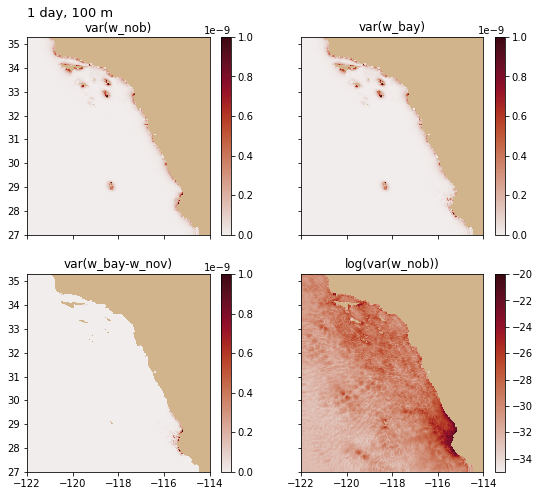

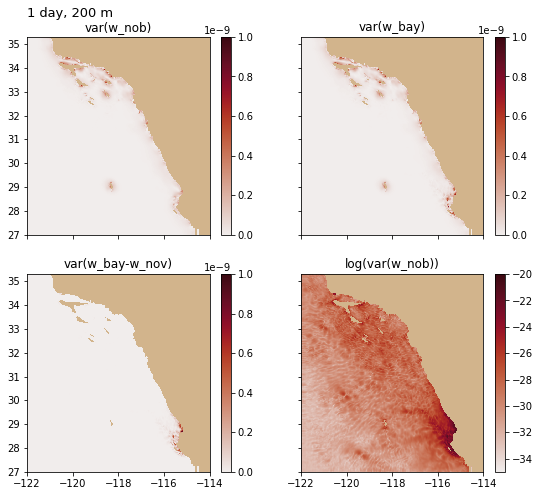

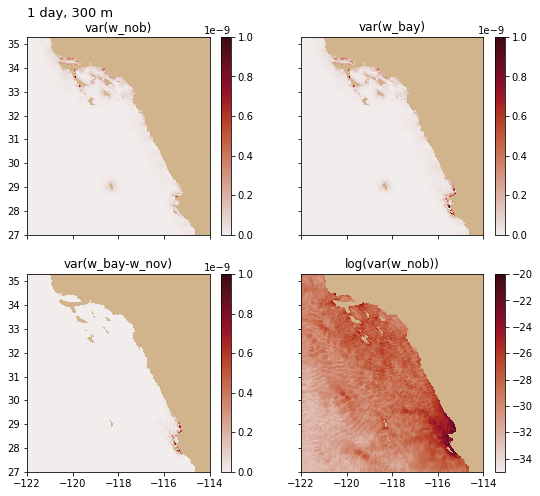

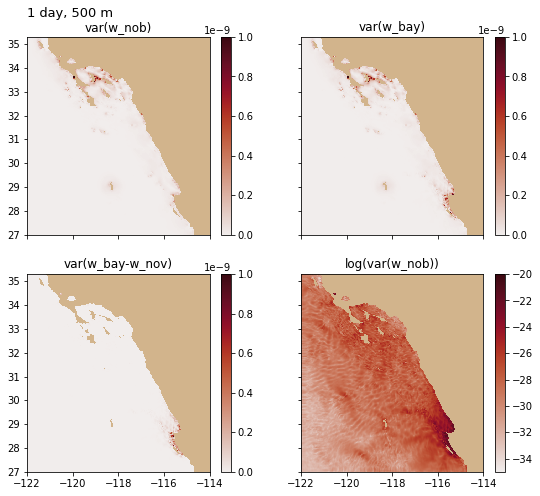

In [17]:
ax1,ax2,ax3,ax4 = plot_var(var1_NB_1d, var1_SVB_1d, var1_dif_1d, label='1 day, 100 m')
ax1,ax2,ax3,ax4 = plot_var(var2_NB_1d, var2_SVB_1d, var2_dif_1d, label='1 day, 200 m')
ax1,ax2,ax3,ax4 = plot_var(var3_NB_1d, var3_SVB_1d, var3_dif_1d, label='1 day, 300 m')
ax1,ax2,ax3,ax4 = plot_var(var4_NB_1d, var4_SVB_1d, var4_dif_1d, label='1 day, 500 m')

In [18]:
tini = 0
tend = 144*2

var1_SVB_2d,var1_NB_2d,var1_dif_2d = get_var(ds,ds2, tini, tend, mask, z1, time, dt=600)
int1_SVB_2d = np.nansum(var1_SVB_2d*masked_area1)/np.nansum(masked_area1)

var2_SVB_2d,var2_NB_2d,var2_dif_2d = get_var(ds,ds2, tini, tend, mask, z2, time, dt=600)
int2_SVB_2d = np.nansum(var2_SVB_2d*masked_area2)/np.nansum(masked_area2)

var3_SVB_2d,var3_NB_2d,var3_dif_2d = get_var(ds,ds2, tini, tend, mask, z3, time, dt=600)
int3_SVB_2d = np.nansum(var3_SVB_2d*masked_area3)/np.nansum(masked_area3)

var4_SVB_2d,var4_NB_2d,var4_dif_2d = get_var(ds,ds2, tini, tend, mask, z4, time, dt=600)
int4_SVB_2d = np.nansum(var4_SVB_2d*masked_area4)/np.nansum(masked_area4)

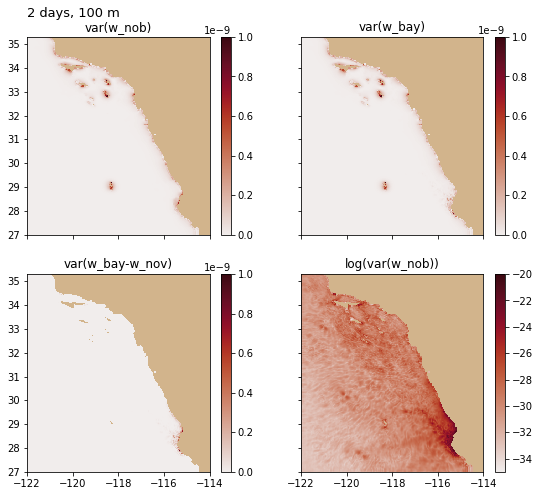

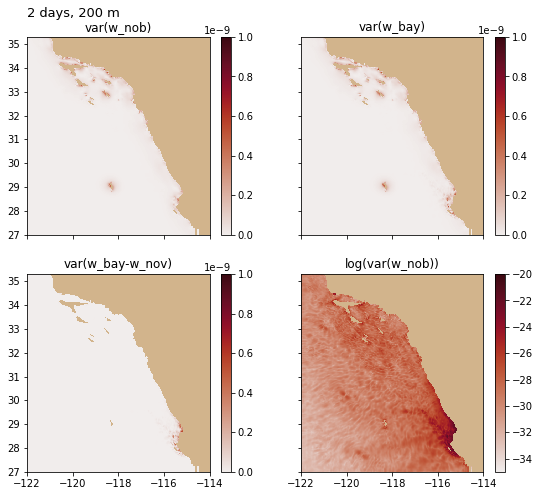

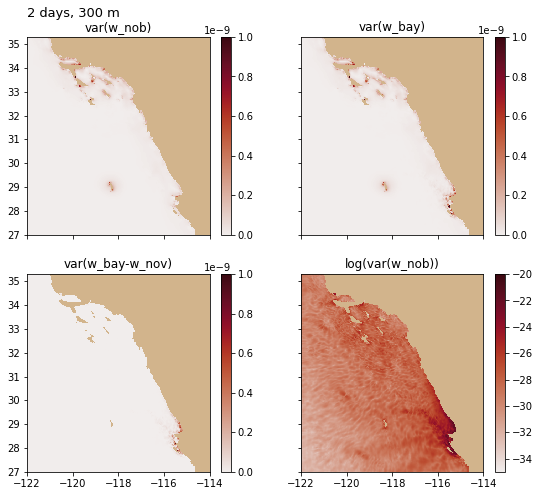

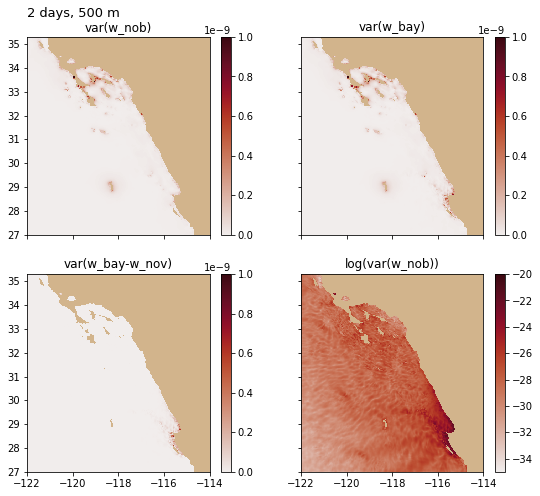

In [19]:
ax1,ax2,ax3,ax4 = plot_var(var1_NB_2d, var1_SVB_2d, var1_dif_2d, label='2 days, 100 m')
ax1,ax2,ax3,ax4 = plot_var(var2_NB_2d, var2_SVB_2d, var2_dif_2d, label='2 days, 200 m')
ax1,ax2,ax3,ax4 = plot_var(var3_NB_2d, var3_SVB_2d, var3_dif_2d, label='2 days, 300 m')
ax1,ax2,ax3,ax4 = plot_var(var4_NB_2d, var4_SVB_2d, var4_dif_2d, label='2 days, 500 m')

In [20]:
tini = 0
tend = 144*3

var1_SVB_3d,var1_NB_3d,var1_dif_3d = get_var(ds,ds2, tini, tend, mask, z1, time, dt=600)
int1_SVB_3d = np.nansum(var1_SVB_3d*masked_area1)/np.nansum(masked_area1)

var2_SVB_3d,var2_NB_3d,var2_dif_3d = get_var(ds,ds2, tini, tend, mask, z2, time, dt=600)
int2_SVB_3d = np.nansum(var2_SVB_3d*masked_area2)/np.nansum(masked_area2)

var3_SVB_3d,var3_NB_3d,var3_dif_3d = get_var(ds,ds2, tini, tend, mask, z3, time, dt=600)
int3_SVB_3d = np.nansum(var3_SVB_3d*masked_area3)/np.nansum(masked_area3)

var4_SVB_3d,var4_NB_3d,var4_dif_3d = get_var(ds,ds2, tini, tend, mask, z4, time, dt=600)
int4_SVB_3d = np.nansum(var4_SVB_3d*masked_area4)/np.nansum(masked_area4)

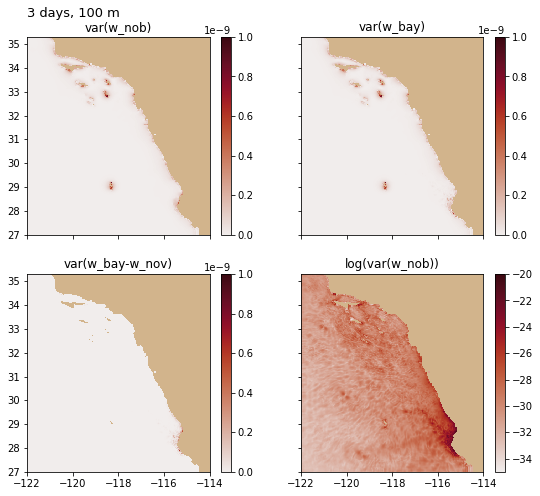

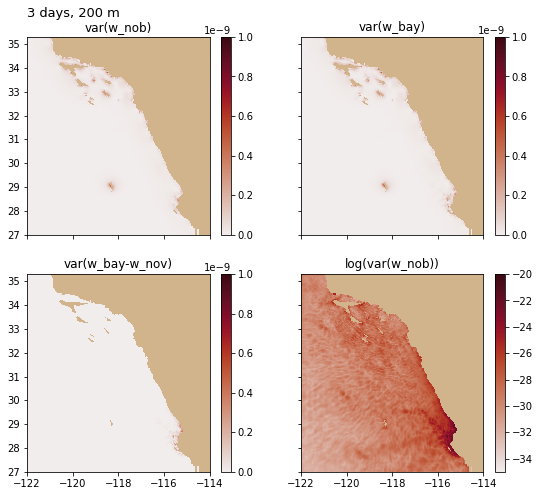

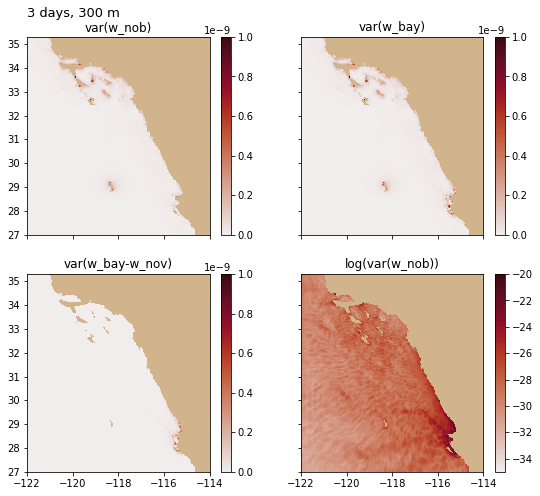

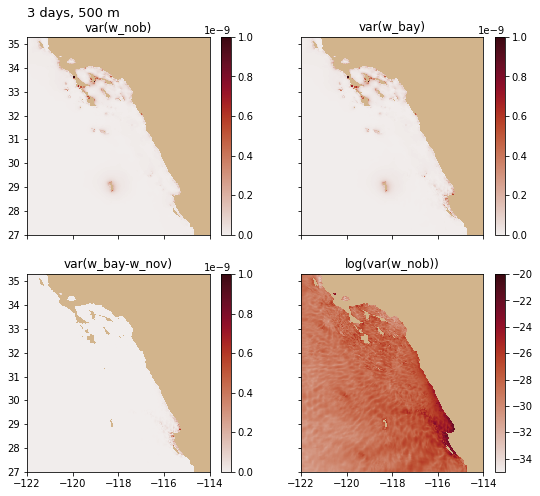

In [21]:
ax1,ax2,ax3,ax4 = plot_var(var1_NB_3d, var1_SVB_3d, var1_dif_3d, label='3 days, 100 m')
ax1,ax2,ax3,ax4 = plot_var(var2_NB_3d, var2_SVB_3d, var2_dif_3d, label='3 days, 200 m')
ax1,ax2,ax3,ax4 = plot_var(var3_NB_3d, var3_SVB_3d, var3_dif_3d, label='3 days, 300 m')
ax1,ax2,ax3,ax4 = plot_var(var4_NB_3d, var4_SVB_3d, var4_dif_3d, label='3 days, 500 m')

In [22]:
tini = 0
tend = 144*5-1

var1_SVB_5d,var1_NB_5d,var1_dif_5d = get_var(ds,ds2, tini, tend, mask, z1, time, dt=600)
int1_SVB_5d = np.nansum(var1_SVB_5d*masked_area1)/np.nansum(masked_area1)

var2_SVB_5d,var2_NB_5d,var2_dif_5d = get_var(ds,ds2, tini, tend, mask, z2, time, dt=600)
int2_SVB_5d = np.nansum(var2_SVB_5d*masked_area2)/np.nansum(masked_area2)

var3_SVB_5d,var3_NB_5d,var3_dif_5d = get_var(ds,ds2, tini, tend, mask, z3, time, dt=600)
int3_SVB_5d = np.nansum(var3_SVB_5d*masked_area3)/np.nansum(masked_area3)

var4_SVB_5d,var4_NB_5d,var4_dif_5d = get_var(ds,ds2, tini, tend, mask, z4, time, dt=600)
int4_SVB_5d = np.nansum(var4_SVB_5d*masked_area4)/np.nansum(masked_area4)

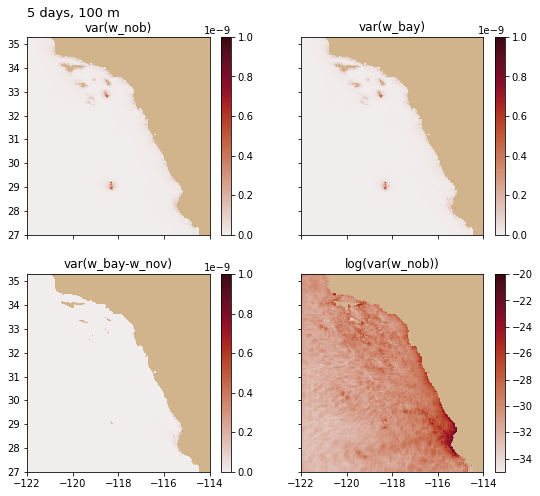

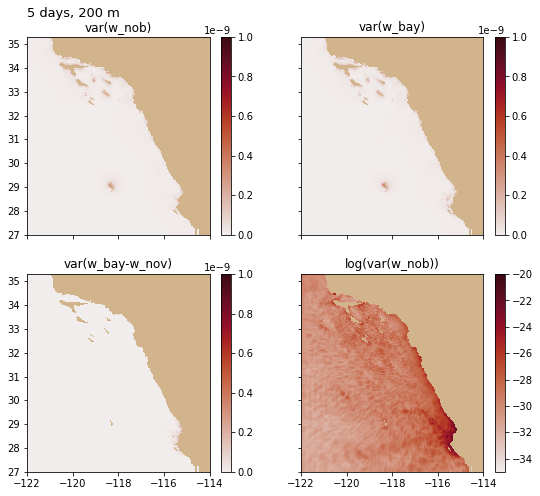

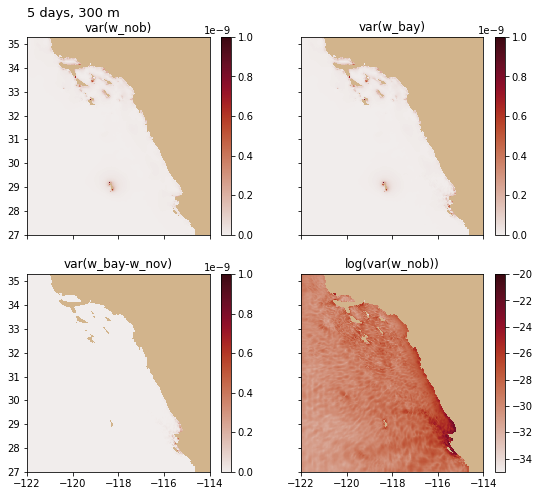

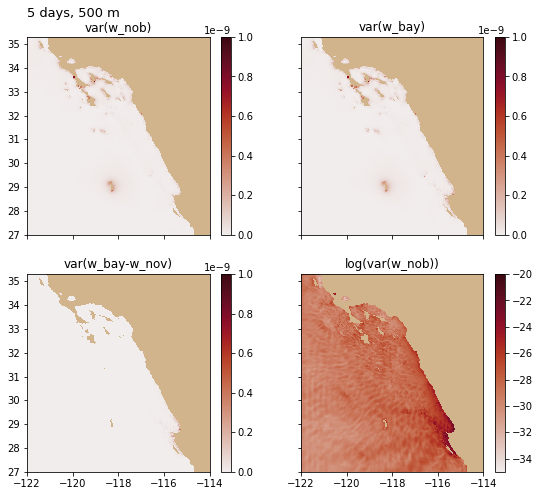

In [23]:
ax1,ax2,ax3,ax4 = plot_var(var1_NB_5d, var1_SVB_5d, var1_dif_5d, label='5 days, 100 m')
ax1,ax2,ax3,ax4 = plot_var(var2_NB_5d, var2_SVB_5d, var2_dif_5d, label='5 days, 200 m')
ax1,ax2,ax3,ax4 = plot_var(var3_NB_5d, var3_SVB_5d, var3_dif_5d, label='5 days, 300 m')
ax1,ax2,ax3,ax4 = plot_var(var4_NB_5d, var4_SVB_5d, var4_dif_5d, label='5 days, 500 m')

In [27]:
int1_NB_1d = np.nansum(var1_NB_1d*masked_area1)/np.nansum(masked_area1)
int2_NB_1d = np.nansum(var2_NB_1d*masked_area2)/np.nansum(masked_area2)
int3_NB_1d = np.nansum(var3_NB_1d*masked_area3)/np.nansum(masked_area3)
int4_NB_1d = np.nansum(var4_NB_1d*masked_area4)/np.nansum(masked_area4)

int1_NB_2d = np.nansum(var1_NB_2d*masked_area1)/np.nansum(masked_area1)
int2_NB_2d = np.nansum(var2_NB_2d*masked_area2)/np.nansum(masked_area2)
int3_NB_2d = np.nansum(var3_NB_2d*masked_area3)/np.nansum(masked_area3)
int4_NB_2d = np.nansum(var4_NB_2d*masked_area4)/np.nansum(masked_area4)

int1_NB_3d = np.nansum(var1_NB_3d*masked_area1)/np.nansum(masked_area1)
int2_NB_3d = np.nansum(var2_NB_3d*masked_area2)/np.nansum(masked_area2)
int3_NB_3d = np.nansum(var3_NB_3d*masked_area3)/np.nansum(masked_area3)
int4_NB_3d = np.nansum(var4_NB_3d*masked_area4)/np.nansum(masked_area4)

int1_NB_5d = np.nansum(var1_NB_5d*masked_area1)/np.nansum(masked_area1)
int2_NB_5d = np.nansum(var2_NB_5d*masked_area2)/np.nansum(masked_area2)
int3_NB_5d = np.nansum(var3_NB_5d*masked_area3)/np.nansum(masked_area3)
int4_NB_5d = np.nansum(var4_NB_5d*masked_area4)/np.nansum(masked_area4)

In [28]:
int1_dif_1d = np.nansum(var1_dif_1d*masked_area1)/np.nansum(masked_area1)
int2_dif_1d = np.nansum(var2_dif_1d*masked_area2)/np.nansum(masked_area2)
int3_dif_1d = np.nansum(var3_dif_1d*masked_area3)/np.nansum(masked_area3)
int4_dif_1d = np.nansum(var4_dif_1d*masked_area4)/np.nansum(masked_area4)

int1_dif_2d = np.nansum(var1_dif_2d*masked_area1)/np.nansum(masked_area1)
int2_dif_2d = np.nansum(var2_dif_2d*masked_area2)/np.nansum(masked_area2)
int3_dif_2d = np.nansum(var3_dif_2d*masked_area3)/np.nansum(masked_area3)
int4_dif_2d = np.nansum(var4_dif_2d*masked_area4)/np.nansum(masked_area4)

int1_dif_3d = np.nansum(var1_dif_3d*masked_area1)/np.nansum(masked_area1)
int2_dif_3d = np.nansum(var2_dif_3d*masked_area2)/np.nansum(masked_area2)
int3_dif_3d = np.nansum(var3_dif_3d*masked_area3)/np.nansum(masked_area3)
int4_dif_3d = np.nansum(var4_dif_3d*masked_area4)/np.nansum(masked_area4)

int1_dif_5d = np.nansum(var1_dif_5d*masked_area1)/np.nansum(masked_area1)
int2_dif_5d = np.nansum(var2_dif_5d*masked_area2)/np.nansum(masked_area2)
int3_dif_5d = np.nansum(var3_dif_5d*masked_area3)/np.nansum(masked_area3)
int4_dif_5d = np.nansum(var4_dif_5d*masked_area4)/np.nansum(masked_area4)

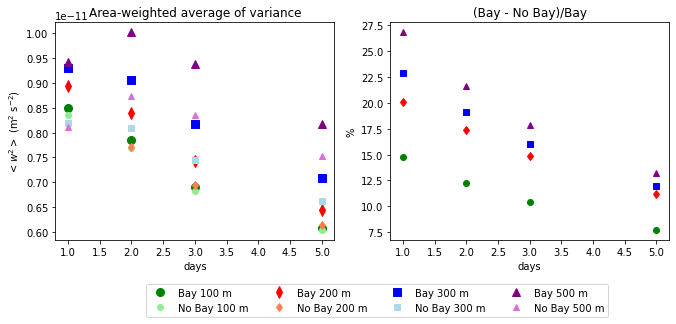

In [56]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(11,4))
ax.plot([1,2,3,5], [int1_SVB_1d, int1_SVB_2d, int1_SVB_3d, int1_SVB_5d],'go',
        markersize=8, label='Bay 100 m')
ax.plot([1,2,3,5], [int1_NB_1d, int1_NB_2d, int1_NB_3d, int1_NB_5d],'o' ,color='lightgreen', 
        label='No Bay 100 m')

ax.plot([1,2,3,5], [int2_SVB_1d, int2_SVB_2d, int2_SVB_3d, int2_SVB_5d],'rd',
        markersize=8, label='Bay 200 m')
ax.plot([1,2,3,5], [int2_NB_1d, int2_NB_2d, int2_NB_3d, int2_NB_5d],'d' ,color='coral', 
        label='No Bay 200 m')

ax.plot([1,2,3,5], [int3_SVB_1d, int3_SVB_2d, int3_SVB_3d, int3_SVB_5d],'bs',
        markersize=8, label='Bay 300 m')
ax.plot([1,2,3,5], [int3_NB_1d, int3_NB_2d, int3_NB_3d, int3_NB_5d],'s' ,color='lightblue', 
        label='No Bay 300 m')

ax.plot([1,2,3,5], [int4_SVB_1d, int4_SVB_2d, int4_SVB_3d, int4_SVB_5d],'^',color='purple',
        markersize=8, label='Bay 500 m')
ax.plot([1,2,3,5], [int4_NB_1d, int4_NB_2d, int4_NB_3d, int4_NB_5d],'^' ,color='orchid', 
        label='No Bay 500 m')

ax.set_xlabel('days')
ax.set_ylabel('$<w^2>$ (m$^2$ s$^{-2}$)')
ax.set_title('Area-weighted average of variance')
ax.legend(bbox_to_anchor=(2,-0.18), ncol=4)

ax1.plot([1,2,3,5], [100*int1_dif_1d/int1_NB_1d,100*int1_dif_2d/int1_NB_2d,100*int1_dif_3d/int1_NB_3d,100*int1_dif_5d/int1_NB_5d],'go')
ax1.plot([1,2,3,5], [100*int2_dif_1d/int2_NB_1d,100*int2_dif_2d/int2_NB_2d,100*int2_dif_3d/int2_NB_3d,100*int2_dif_5d/int2_NB_5d],'rd')
ax1.plot([1,2,3,5], [100*int3_dif_1d/int3_NB_1d,100*int3_dif_2d/int3_NB_2d,100*int3_dif_3d/int3_NB_3d,100*int3_dif_5d/int3_NB_5d],'bs')
ax1.plot([1,2,3,5], [100*int4_dif_1d/int4_NB_1d,100*int4_dif_2d/int4_NB_2d,100*int4_dif_3d/int4_NB_3d,100*int4_dif_5d/int4_NB_5d],'^', color='purple')


ax1.set_xlabel('days')
ax1.set_title(r'(Bay - No Bay)/Bay')
ax1.set_ylabel('%')
ax1.set_title
plt.show()
